## Anomaly Detection in Finance:  Credit Card Fraud Detection
####  Synthesized Techniques of Unsupervised Learning and its Application

# Abstract

Outlier detection with machine learning algorithms is applicable in many fields. Automated transaction monitoring is an area where outlier detection is being used, especially in fighting financial crimes like credit card fraud and money laundering.

`We will see the application of anomaly detection technique on credit card transactions through unsupervised machine learning methods.`

# What and Why Outlier Detection?
Outlier detection, also known as anomaly detection is frequently used to identify rare patterns and events which raise suspicions. From health monitoring (brain scan or MRI scan) and event detection in sensor networks to ecosystem disturbance, we can find many applications of anomaly detection.

In a real world scenario, an unsupervised model is used primarily as a seed to create labelled data. However often we run into issues in the process. 

Take detecting the probability of an employee's securities fraud as an example. The dataset that the organization will look into is very high dimensional and complex. Without indepth domain knowledge, formulating algorithms to detect fraud is very difficult. Furthermore, issues such as confidentiality makes it even harder to do the job.

This is where unsupervised learning shines. Even with very limited domain knowledge, an unsupervised algorithm can be used to create a list of possible anomalies or outliers which will be reported to an auditing team which then generates the true labels by their investigation. Over time when enough data labels are created, the unsupervised problem can be reformed as a supervised machine learning problem.

Here we will discuss a number of unsupervised machine learning algorithms which have their own distinctive approach. `We will be able to compare the benchmakr of each model and then demonstrate how to make a list of flagged credit card transactions as fraudulent.`

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, roc_curve, roc_auc_score,accuracy_score,precision_recall_curve,f1_score
from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans
from sklearn.externals import joblib

from pyod.utils import precision_n_scores
from pyod.utils.data import evaluate_print

/Users/bringmesalad/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [84]:
#Loading dataset
df_origin=pd.read_csv('creditcard.csv') #Keeping the original for visualization and such
df = pd.read_csv('creditcard.csv') #dataframe for work

# Introduction of dataset

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, original features are anonymized and only the amount and time of transaction is revealed. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# Exploratory Data Analysis 
During EDA phase, we will explore our data in various ways and though our focus here is to apply unsupervised machine learning model but data came in with the label so we will use it for EDA part only.

However we won't see the labels of dataset during our core part of unsupervised machine learning part of our project.

In [3]:
df.columns #Checking columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [3]:
# Data was clean, no need to do any cleaning
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

0    284315
1       492
Name: Class, dtype: int64


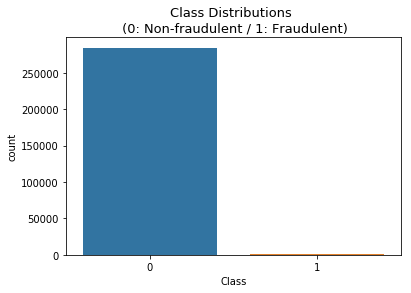

In [5]:
# Highly imbalanced data
print(df.Class.value_counts())  #Fradulent transactions are only .17% of the total dataset.

sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: Non-fraudulent / 1: Fraudulent)', fontsize=13)

plt.savefig('Class Distribution.png')

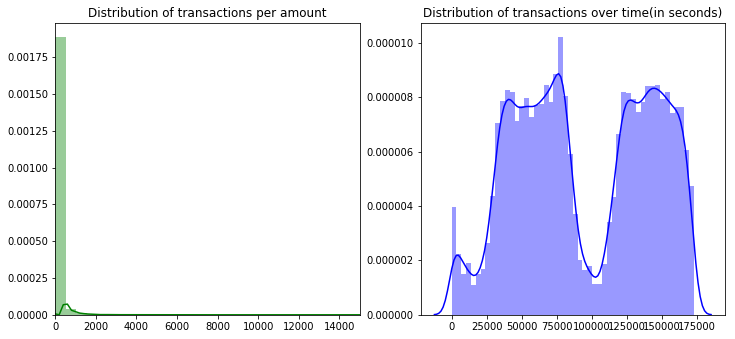

In [4]:
# To see the distribution of 
df.describe()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df.Amount.values,color='green')
plt.xlim([0,15000])
plt.title('Distribution of transactions per amount')
plt.subplot(1,2,2)
sns.distplot(df.Time.values,color='blue')
plt.subplots_adjust(hspace=2,top=0.8)
plt.title('Distribution of transactions over time(in seconds)')
plt.show()

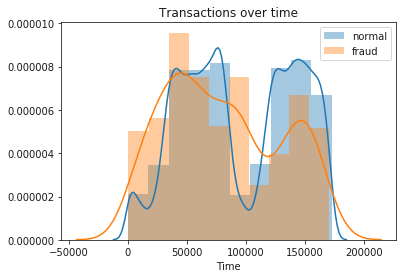

In [8]:
# Distribution of normal and fruadulent transactions over time in 2 days.(In seconds)
nonfraudtime = df[df['Class']==0]['Time']
fraudtime = df[df['Class']==1]['Time']

plt.figure()
sns.set_color_codes('pastel')
sns.distplot(nonfraudtime,bins=10,label='normal')
sns.distplot(fraudtime,bins=10,label='fraud')
plt.title('Transactions over time')
plt.legend()
plt.show()

We were informed that the data is scaled and PCA'ed for the protection of personal information. Naturally I'm assuming that Scaling has been done because PCA should be implemented after normalizing.

However we can see that Time and the Amount is not scaled.

In [87]:
# Converting Time feature which is in seconds to hours
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

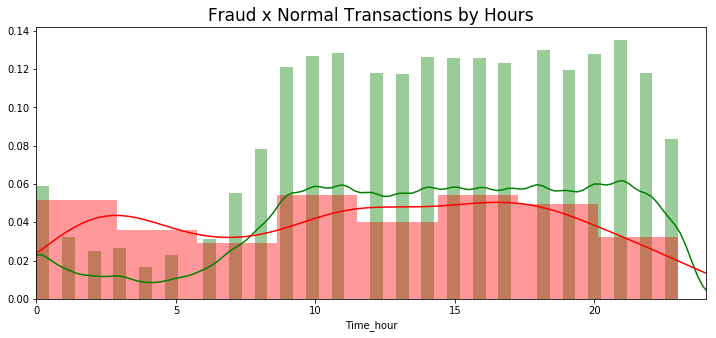

In [7]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], 
             color='green')
sns.distplot(df[df['Class'] == 1]["Time_hour"], 
             color='red')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([0,24])
plt.show()

# Feature Engineering for Unsupervised learning

Suspicious Amount

In [85]:
#First assumption I made for suspicious amount is that normally due to various reasons including sales tax and such, transaction amount is rarely rounded numbers.
#Setting range of suspicious amount which are rounded numbers
suspiciousamounts = range(0,25700,1)

# Make a series that have boolean whether they are rounded amount or not
sus_amount=df['Amount'].isin(suspiciousamounts)
# Create new column 'suspicious_amount' and make it binary 0 and 1
df['suspicious_amount']=np.where(sus_amount==False,0,1)

Off-Peak Hours

In [88]:
# Second assumption I made is that credit card transactions normally happen from 7am to midnight or 1am. Transactions that happen during late night from 1am to 6am is probably a bit suspicious.
# Setting a range of off-peak(suspicious) timelines which is from 1 am to 6am
off_range = range(1,6)

# Boolean series whether the transaction belongs to suspicious timelines
offpeak_hours = df['Time_hour'].isin(off_range)

# Create a new column 'suspicious_hours' and it will store binary features
df['suspicious_hours'] = np.where(offpeak_hours==False,0,1)

Scaling and dropping unnecessary features.

In [89]:
#Scaling
rscaler = RobustScaler() #Seeing that amount and time is unevenly distributed, we can try robust scaler since it's less vulnerable to outliers

# Replacing existing columns
df['amount_scaled'] = rscaler.fit_transform(df['Amount'].values.reshape(-1,1))

# Drop unnecessary features including 'Time'
df.drop(columns=['Time','Amount','Time_hour'],inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,suspicious_amount,suspicious_hours,amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,0,0.670579


Visualization before applying unsupervised learning to see what we are dealing with.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you how the data is arranged in a high-dimensional space.
(The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function.)

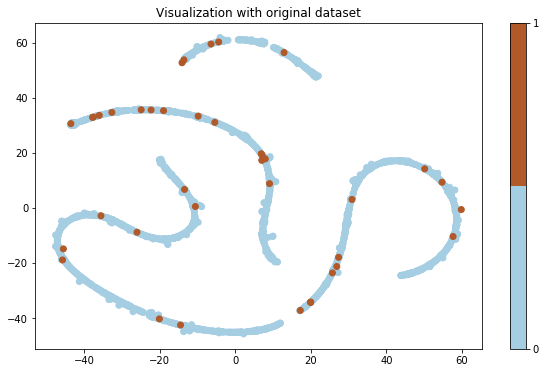

In [11]:
# Visualization with the original dataset(Without Feature engineering)
df_plt=df_origin[df_origin['Class']==0].sample(2000) # 2000 sample 'Normal' datapoints 
df_plt_pos=df_origin[df_origin['Class']==1].sample(40) #40 sample 'Fraud' datapoints 
df_plt=pd.concat([df_plt,df_plt_pos]) #Concat normal and fraud datapoints
y_plt=df_plt['Class'] # Separate 'Class' feature
X_plt=df_plt.drop('Class',1) # Dataset without 'Class' feature

# T-SNE it with 2 components so it can be visualized 
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt,cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('Visualization with original dataset')
plt.savefig('Tsne.jpeg')
plt.show()

What we see above are normal and fraudulent transactions. We can see that both type of transactions are very alike and hard to separate it using distance or density based clustering. It is premature to say but unsupervised ML methods with distance base approach might not be so effective because fraudulent transactions are not too far away from the normal transactions.

It is possible we can't do much meaningful clustering to detect anomalies(Fraudulent transactions) with the original dataset judging from the visualization above. 

Let's do another visualization with dataset('df') which has extra infomation(suspicious_amount and suspicious_hours) we have added with feature engineering. 

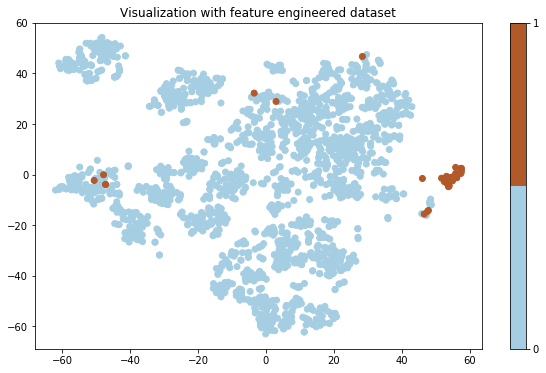

In [13]:
# Visualization with dataset that feature engineered 'suspicious_amount and suspicious_hours' feature
df_plt=df[df['Class']==0].sample(2000) 
df_plt_pos=df[df['Class']==1].sample(40)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',1)

# T-SNE
X_embedded = TSNE(n_components=2).fit_transform(X_plt)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('Visualization with feature engineered dataset')
plt.savefig('Tsne2.jpeg')
plt.show()

We can see that adding informations through feature enginnering opens up a possibility to do separation through unsupervised machine learning.

Due to the limit of dataset we have(features have been anonymized), I could only add 2 informative features but with real dataset where we have critical informations about the transactions, we would have been able to add more features to make more effective unsupervised ML.

Now let's do some machine learning.

 # Unsupervised Learning Methods

There are various types of unsupervised learning method we could apply. Here are the list of the models I have tried. I will briefly introduce each methods. 


# Probability Based
- Angle Based Outlier Detector. ABOD assumes that the `variance of angles between pairs of the remaining datapoints is small if the datapoint is the outlier`. It is supposed to fight the limit of proximity based approach with curse of dimensionality. 
<br>

- Stochastic Outlier Selection (SOS). Unfortunately we found that this one is not working with our dataset. It bugs out.

# Proximity Based

- Local Outlier Factor. The LOF is a calculation that `looks at the neighbors of a certain point to find out its density` and compare this to the density of other points. __If the density of a point is much smaller than the densities of its neighbors, the point is far from dense areas_ hence, an outlier.__

<br> 

- Clustering-Based Local Outlier Factor(CBLOF). It __classifies the data into small clusters and large clusters__. The `anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster`.

<br>

- Local Correlation Integral (LOCI). Same with SOS, it bugs out and shut down the kernel.

<br>

- K Nearest Neighbors(KNN). KNN is normally used as a supervised learning method but for any data point, the `distance to its kth nearest neighbor could be viewed as the outlying score`.

<br>

- HBOS. Histogram Based Outlier Score assumes the feature independence and calculates the degree of anomalies by building histograms. The basic idea is, that for each feature of the dataset, a histogram is created. Then, for each instance in the dataset, the inverse height of the bins it resides (representing the density estimation) of all features are multiplied.

<br>

- Isolation Forest(IF). It uses random forest-like approach where it does recursive partitioning of its features. Basic assumption is that the anomalies will be outstanding and easily separable. Isolation Forest will choose random features to make trees and start separating instances. Shorter it takes to be separated, higher chances of it being anomaly.


# Semi Supervied Learning
- One Class Support Vector Machine. One-class SVMs tries to separate the origin from the data instances in the kernel space, in other words it finds a small region where most of the data lies and label data points in this region as one class. One-class SVM is trained only on anomaly-free data and later, the SVM classifies anomalies and normal data in the test set.

- Autoencoder [Neural Network] 

In [14]:
# Removing 'Class' from dataset so we can work without labels and do unsupervised learning
X = df.drop('Class',axis=1)
y = df['Class']

Note before applying unsupervised outlier detection models
- Contamination is a parameter you set for the fraction of datapoints your model will assign as an outlier. `The default value is at 0.1 but considering the fact that portion of credit card fraud was by average 0.1% I will set it as 0.01 for this project`.
- Other than Contamination parameter, we will try to keep other parameters as default as possible for this project so we can be fair between models we try.

# Angle-based Outlier Detector (ABOD)

In [19]:
%%time
from pyod.models.abod import ABOD #Import model

#Using 'fast' parameter to reduce computation time, n_neighbors will be 5 as it is the default setting. We will try to keep the hyperparameters as default as much as possible to compare the performance and to honour the meaning of unsupervised learning. Basically it will only check the 5 nearest datapoints for the variance of angles. Reason why we will keep the contamination at 0.01 is because the default setting is 0.1 which is 10% of the dataset will be flagged as outlier which is too high considering the fact that about 0.1% of credit card transactions were found to be fraudulent.
FABOD = ABOD(method='fast',contamination=0.01,n_neighbors=5) 

FABOD.fit(X,y=None)

CPU times: user 15min 16s, sys: 4.45 s, total: 15min 21s
Wall time: 21min 8s


ABOD(contamination=0.01, method='fast', n_neighbors=5)

In [20]:
%%time
FABOD_predict = FABOD.predict(X)

CPU times: user 16min 41s, sys: 3.9 s, total: 16min 45s
Wall time: 16min 50s


In [26]:
# Checking the distribution of normal vs outliers
np.unique(FABOD_predict,return_counts=True) 

# It is clearly not working well with our dataset probably because I used 'fast' and only counted 5 nearest datapoints. I imagine it will be effective with 'old' behaviour which counts all the remaining pairs which will be computationally very heavy. We will not pursue down that road.

(array([0]), array([284807]))

In [25]:
# Backup 
X_backup = df.iloc[:,-4:].copy() #Making copy dataset for saving ML results
joblib.dump(FABOD, 'FABOD.pkl')  # Dumping model
X_backup['FABOD_predict']=FABOD_predict

['FABOD.pkl']

# Local Outlier Factor (LOF)

In [27]:
from pyod.models.lof import LocalOutlierFactor
lof = LocalOutlierFactor(n_jobs=-1,contamination=0.01)

In [28]:
%%time
lof.fit(X)  #Fitting

CPU times: user 30min 6s, sys: 8.13 s, total: 30min 14s
Wall time: 9min 25s


LocalOutlierFactor(algorithm='auto', contamination=0.01, leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=-1,
                   n_neighbors=20, novelty=False, p=2)

In [29]:
%%time
lof_predict = lof.fit_predict(X) # Prediction

CPU times: user 30min 2s, sys: 8.14 s, total: 30min 10s
Wall time: 9min 12s


In [32]:
np.unique(lof_predict,return_counts=1) #Checking Distribution

(array([-1,  1]), array([  2849, 281958]))

In [33]:
# Convert the format of prediction values so that flagged datapoint is 1 and normal datas are 0.
lof_predict[lof_predict == 1] = 0
lof_predict[lof_predict == -1] = 1

In [54]:
n_errors = (lof_predict != y).sum() #This is to show how many errors it has made predicting 
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,lof_predict)) #Accuracy score of model, however the dataset is very imbalanced it will alawys print very high accuracy hence not a reliable metric to evaluate models.
print("Classification Report :")
print(classification_report(y,lof_predict)) 

Local Outlier Factor: 3335
Accuracy Score :
0.9882903158981345
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.00      0.01      0.00       492

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      0.99      0.99    284807



In [31]:
lof_score=lof.negative_outlier_factor_  #The outlier scores of the training data.

array([-1.08919753, -1.06399059, -1.1600584 , ..., -1.49123234,
       -1.0205531 , -1.0658683 ])

In [38]:
evaluate_print('LOF',y,lof_score) #It prints the AUC score. It's below 0.5 which is not at all promising model for the dataset we use. 

LOF ROC:0.4944, precision @ rank n:0.0


# Clustering Based Local Outlier Factor (CBLOF)

In [133]:
from pyod.models.cblof import CBLOF
cblof = CBLOF(contamination=0.01,n_jobs=-1)

In [160]:
%%time
cblof.fit(X) #Fitting

CPU times: user 561 ms, sys: 205 ms, total: 766 ms
Wall time: 11.3 s


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=-1, random_state=None,
   use_weights=False)

In [161]:
%%time
cblof_predict= cblof.predict(X) #Predicting

CPU times: user 417 ms, sys: 33.7 ms, total: 451 ms
Wall time: 259 ms


In [162]:
cblof_proba = cblof.predict_proba(X)[:,1] #Probability of datapoints being normal and outlier
cblof_score = cblof.decision_scores_ #The outlier scores of the training data. High score means more likely to be an outlier.

In [163]:
np.unique(cblof_predict,return_counts=True) #Distribution

(array([0, 1]), array([281958,   2849]))

In [164]:
n_errors = (cblof_predict != y).sum() #Number of errors it has made predicting.
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,cblof_predict))
print("Classification Report :") #Classification Report
print(classification_report(y,cblof_predict))

Local Outlier Factor: 2721
Accuracy Score :
0.9904461617867538
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.11      0.63      0.19       492

    accuracy                           0.99    284807
   macro avg       0.55      0.81      0.59    284807
weighted avg       1.00      0.99      0.99    284807



# Local Correlation Integral (LOCI).  Bugged out

# k-Nearest Neighbors Detector (KNN)

In [50]:
from pyod.models.knn import KNN
knn = KNN(contamination=0.01,n_jobs=-1)

In [51]:
%%time
knn.fit(X,y=None) #Fitting

CPU times: user 18min 20s, sys: 4.74 s, total: 18min 25s
Wall time: 5min 30s


KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [52]:
%%time
knn_predict = knn.predict(X) #Prediction

CPU times: user 1h 37min 30s, sys: 42.2 s, total: 1h 38min 12s
Wall time: 1h 40min 17s


In [39]:
np.unique(knn_predict,return_counts=True) # Distribution

(array([0, 1]), array([282286,   2521]))

In [53]:
%%time
knn_proba = knn.predict_proba(X)[:,1] #Probability of datapoints being normal and outlier

CPU times: user 1h 38min 51s, sys: 45.6 s, total: 1h 39min 37s
Wall time: 2h 11min 1s


In [56]:
knn_score = knn.decision_scores_ #The outlier scores of the training data. High score means more likely to be an outlier.

In [56]:
n_errors = (knn_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,knn_predict))
print("Classification Report :")
print(classification_report(y,knn_predict))

Local Outlier Factor: 2611
Accuracy Score :
0.9908323882488843
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.08      0.41      0.13       492

    accuracy                           0.99    284807
   macro avg       0.54      0.70      0.56    284807
weighted avg       1.00      0.99      0.99    284807



In [59]:
evaluate_print('knn',y,knn_score) #It prints the ROC AUC score.

knn ROC:0.9394, precision @ rank n:0.0955


# HBOS

In [183]:
from pyod.models.hbos import HBOS
hbos = HBOS(contamination=0.01)

In [212]:
%%time
hbos.fit(X,y=None) #Fitting

CPU times: user 478 ms, sys: 66.8 ms, total: 545 ms
Wall time: 427 ms


HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)

In [213]:
%%time
hbos_predict = hbos.predict(X) #Prediction

CPU times: user 328 ms, sys: 16.9 ms, total: 345 ms
Wall time: 220 ms


In [214]:
np.unique(hbos_predict,return_counts=True) #Distribution

(array([0, 1]), array([281958,   2849]))

In [215]:
hbos_proba = hbos.predict_proba(X)[:,1] #Probability of datapoints being normal and outlier

hbos_score = hbos.decision_scores_ #The outlier scores of the training data. High score means more likely to be an outlier.

In [216]:
n_errors = (hbos_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,hbos_predict))
print("Classification Report :")
print(classification_report(y,hbos_predict))

Local Outlier Factor: 2633
Accuracy Score :
0.9907551429564583
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.12      0.72      0.21       492

    accuracy                           0.99    284807
   macro avg       0.56      0.86      0.60    284807
weighted avg       1.00      0.99      0.99    284807



In [217]:
evaluate_print('HBOS',y,hbos_score) #It prints the ROC AUC score.

HBOS ROC:0.9477, precision @ rank n:0.3971


# Isolation Forest

In [19]:
from pyod.models.iforest import IForest

In [124]:
%%time
#Isolation Forest
IF = IForest(n_estimators=100,contamination=0.01,n_jobs=-1)
IF.fit(X) #Fitting

CPU times: user 37.3 s, sys: 3.81 s, total: 41.1 s
Wall time: 20.9 s


IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=None, verbose=0)

In [125]:
%%time
IF_predict = IF.predict(X) #Prediction

CPU times: user 16.3 s, sys: 949 ms, total: 17.2 s
Wall time: 9.29 s


In [126]:
np.unique(IF_predict,return_counts=True)

(array([0, 1]), array([281958,   2849]))

In [127]:
IF_proba = IF.predict_proba(X)[:,1] #Probability of datapoints being normal and outlier
IF_score = IF.decision_scores_ #The outlier scores of the training data.

In [128]:
n_errors = (IF_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,IF_predict))
print("Classification Report :")
print(classification_report(y,IF_predict))

Local Outlier Factor: 2731
Accuracy Score :
0.9904110502901965
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.11      0.62      0.18       492

    accuracy                           0.99    284807
   macro avg       0.55      0.81      0.59    284807
weighted avg       1.00      0.99      0.99    284807



In [129]:
evaluate_print('IF',y,IF_score) #It prints the ROC AUC score.

IF ROC:0.9489, precision @ rank n:0.3008


# Bonus: Semi-unsupervised Machine Learning

# One Clss SVM

In [41]:
# Before we do One Class Support Vector Machine we need to prepare some datasets
non_fraud = df[df['Class']== 0] #Only normal transactions
fraud = df[df['Class']== 1] #Fraudulent transactions

# Spltting normal transactions into one for training and one for validation later on
df_train, val = train_test_split(non_fraud, test_size=0.20)

df_val = val.drop('Class',axis=1) # Drop Class Column from validation normal transactions
df_fraud = fraud.drop('Class',axis=1) #Drop Class Column from fraudulent transactions 

y_val = val['Class'] #Class of validation noraml transactions
y_fraud = fraud['Class'] #Class of fraudulent transactions
y_testval = pd.concat([y_val, y_fraud]) #Combine Classes of above two, will be used for evaluation
y_testval = np.array(y_testval)  
df_testval = pd.concat([df_val, df_fraud]) #Combine validation normal transactions and fraudulent transactions

In [42]:
%%time
from sklearn import svm
# Instantiate model
ocsvm = svm.OneClassSVM(kernel='rbf', nu=0.01,gamma=0.007)

ocsvm.fit(df_train.drop('Class',axis=1))

CPU times: user 9min 40s, sys: 3.17 s, total: 9min 43s
Wall time: 9min 55s


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.007, kernel='rbf',
            max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [44]:
%%time
ocsvm_predict = ocsvm.predict(df_testval)
np.unique(ocsvm_predict,return_counts=True)

CPU times: user 5.54 s, sys: 56.1 ms, total: 5.59 s
Wall time: 5.59 s


(array([-1,  1]), array([  975, 56380]))

In [45]:
ocsvm_predict[ocsvm_predict == 1] = 0
ocsvm_predict[ocsvm_predict == -1] = 1
np.unique(ocsvm_predict,return_counts=True)

(array([0, 1]), array([56380,   975]))

In [49]:
n_errors = (ocsvm_predict != y_testval).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y_testval,ocsvm_predict))
print("Classification Report :")
print(classification_report(y_testval,ocsvm_predict))
print("Confusion Matrix")
print(confusion_matrix(y_testval,ocsvm_predict))

Local Outlier Factor: 663
Accuracy Score :
0.988440414959463
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.41      0.82      0.55       492

    accuracy                           0.99     57355
   macro avg       0.71      0.90      0.77     57355
weighted avg       0.99      0.99      0.99     57355

Confusion Matrix
[[56290   573]
 [   90   402]]


# Bagging models
In terms of outlier detection, certain models invovle randomness in their machine learning process. In order to mitigate such issues, we can use bagging methods to average out the anomaly scores hence the anomaly points.

We can control the number of estimators by changing n_estimators parameter and still assigning contamination parameter as 0.01.

In [90]:
from pyod.models.feature_bagging import FeatureBagging

In [140]:
%%time
FB_IF = FeatureBagging(base_estimator=IForest(),n_estimators=25,contamination=0.01,n_jobs=-1)
FB_IF.fit(X)

CPU times: user 13min 29s, sys: 58.2 s, total: 14min 27s
Wall time: 7min 46s


FeatureBagging(base_estimator=IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.01,
        estimator_params={}, max_features=1.0, n_estimators=25, n_jobs=-1,
        random_state=None, verbose=0)

In [141]:
%%time
FB_IF_predict = FB_IF.predict(X)

CPU times: user 5min 54s, sys: 23.4 s, total: 6min 17s
Wall time: 3min 22s


In [142]:
np.unique(FB_IF_predict,return_counts=True)

(array([0, 1]), array([281958,   2849]))

In [143]:
FB_IF_proba = FB_IF.predict_proba(X)[:,1]
FB_IF_score = FB_IF.decision_scores_

In [144]:
n_errors = (FB_IF_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,FB_IF_predict))
print("Classification Report :")
print(classification_report(y,FB_IF_predict))

Local Outlier Factor: 2737
Accuracy Score :
0.9903899833922621
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.11      0.61      0.18       492

    accuracy                           0.99    284807
   macro avg       0.55      0.80      0.59    284807
weighted avg       1.00      0.99      0.99    284807



In [96]:
evaluate_print('Ensemble of 25 IF',y,FB_IF_score)

Ensemble of 25 IF ROC:0.9477, precision @ rank n:0.2764


# Bagging for HBOS

In [218]:
%%time
FB_hbos = FeatureBagging(base_estimator=HBOS(),n_estimators=25,contamination=0.01,n_jobs=-1)
FB_hbos.fit(X)

CPU times: user 8.79 s, sys: 665 ms, total: 9.46 s
Wall time: 5.93 s


FeatureBagging(base_estimator=HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.01,
        estimator_params={}, max_features=1.0, n_estimators=25, n_jobs=-1,
        random_state=None, verbose=0)

In [219]:
%%time
FB_hbos_predict = FB_hbos.predict(X)
np.unique(FB_IF_predict,return_counts=True)

CPU times: user 5.92 s, sys: 348 ms, total: 6.27 s
Wall time: 3.55 s


(array([0, 1]), array([281958,   2849]))

In [220]:
FB_hbos_proba = FB_hbos.predict_proba(X)[:,1]
FB_hbos_score = FB_hbos.decision_scores_

In [221]:
n_errors = (FB_hbos_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,FB_hbos_predict))
print("Classification Report :")
print(classification_report(y,FB_hbos_predict))

Local Outlier Factor: 2630
Accuracy Score :
0.9907656764054255
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.12      0.72      0.21       492

    accuracy                           0.99    284807
   macro avg       0.56      0.86      0.60    284807
weighted avg       1.00      0.99      0.99    284807



In [222]:
evaluate_print('Ensemble of 25 HBOS',y,FB_hbos_score)

Ensemble of 25 HBOS ROC:0.9474, precision @ rank n:0.3943


# Bagging for CBLOF

In [145]:
%%time
FB_cblof = FeatureBagging(base_estimator=CBLOF(),n_estimators=25,contamination=0.01,n_jobs=-1)
FB_cblof.fit(X)

CPU times: user 7min 44s, sys: 37.9 s, total: 8min 22s
Wall time: 7min 27s


FeatureBagging(base_estimator=CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=1, random_state=None,
   use_weights=False),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.01,
        estimator_params={}, max_features=1.0, n_estimators=25, n_jobs=-1,
        random_state=None, verbose=0)

In [146]:
%%time
FB_cblof_predict = FB_cblof.predict(X)

CPU times: user 7.5 s, sys: 729 ms, total: 8.23 s
Wall time: 4.62 s


In [147]:
np.unique(FB_cblof_predict,return_counts=True)

(array([0, 1]), array([281958,   2849]))

In [148]:
FB_cblof_proba = FB_cblof.predict_proba(X)[:,1]
FB_cblof_score = FB_cblof.decision_scores_

In [149]:
n_errors = (FB_cblof_predict != y).sum()
print(f'Local Outlier Factor: {n_errors}')

print("Accuracy Score :")
print(accuracy_score(y,FB_cblof_predict))
print("Classcblofication Report :")
print(classification_report(y,FB_cblof_predict))

Local Outlier Factor: 2727
Accuracy Score :
0.9904250948888195
Classcblofication Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.11      0.62      0.18       492

    accuracy                           0.99    284807
   macro avg       0.55      0.81      0.59    284807
weighted avg       1.00      0.99      0.99    284807



In [123]:
evaluate_print('Ensemble of 25 CBLOF',y,FB_cblof_score)

Ensemble of 25 CBLOF ROC:0.9583, precision @ rank n:0.2297


# Benchmark Comparison

We are going to take a look at some benchmarks from time it takes to run to ROC AUC, Recall and F1 score. By principle it is against the whole purpose of unsupervised learning to check the recall score and AUC score but it's for the curiousity of mine. 

Train time and Prediction Time.

Reason why I check time it takes to run is to replicate the real life scenario as much as possible because we want to use this for credit card fraud detection. With the amount of credit card transaction coming in every hour and day, it is not practical to use the model that takes too long to run.

In [43]:
## Performance Plot
train_times={
    'KNN': 570.0,
    'LOF':565.0,
    'IF': 19.0,
    'HBOS':0.4,
    'CBLOF': 13.0,
    'OCSVM': 773.0
}

prediction_times={
    'KNN': 6017.0,
    'LOF': 552.0,
    'IF':9.5,
    'HBOS': 0.2,
    'CBLOF': 0.3,
    'OCSVM': 5.3
}

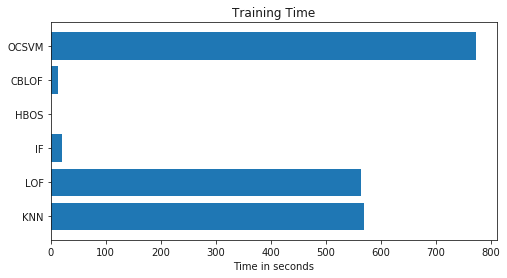

In [298]:
plt.figure(figsize=(8,4))
plt.title('Training Time')
plt.barh(range(len(train_times)), list(train_times.values()), align='center',)
plt.yticks(range(len(train_times)), list(train_times.keys()))
plt.xlabel('Time in seconds')
plt.savefig('Training Time.jpeg')
plt.show()

We see that KNN and Local Outlier Factor takes about 9 minutes and OneClass SVM takes about 13 minutes to train as opposed to other 3 models which take less than a minute. HBOS takes less than a second.

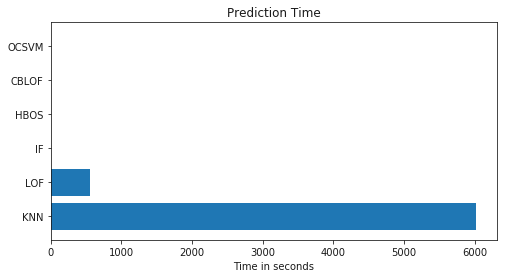

In [299]:
plt.figure(figsize=(8,4))
plt.title('Prediction Time')
plt.barh(range(len(prediction_times)), list(prediction_times.values()), align='center')
plt.yticks(range(len(prediction_times)), list(prediction_times.keys()))
plt.xlabel('Time in seconds')
plt.savefig('Prediction Time.jpeg')
plt.show()

KNN takes extremely long to predict due to its heavy computation part. LOF will take about 9 minutes to predict yet other 3 models will take less than 10 seconds to run.

Performance Plot (ROC_AUC score, Recall score and F1 score)

In [52]:
hbos_proba = X_backup['hbos_proba']
IF_predict = X_backup['IF_predict']
knn_predict = X_backup['knn_predict']
cblof_predict = X_backup['cblof_predict']
lof_predict = X_backup['lof_predict']

In [130]:
## Performance Plot
auc_scores={
    'IF': roc_auc_score(y, IF_proba),
    'KNN': roc_auc_score(y,knn_proba),
    'CBLOF': roc_auc_score(y,cblof_proba),
    'LOF': roc_auc_score(y,lof_score),
    'HBOS':roc_auc_score(y,hbos_proba)
}

recall_scores={
    'IF':recall_score(y, IF_predict),
    'KNN': recall_score(y,knn_predict),
    'CBLOF': recall_score(y,cblof_predict),
    'LOF': recall_score(y,lof_predict),
    'HBOS':recall_score(y,hbos_predict),
    'OCSVM':recall_score(y_testval,ocsvm_predict)
}

F1_score = {
    'IF':f1_score(y, IF_predict),
    'KNN': f1_score(y,knn_predict),
    'CBLOF': f1_score(y,cblof_predict),
    'LOF': f1_score(y,lof_predict),
    'HBOS':f1_score(y,hbos_predict),
    'OCSVM': f1_score(y_testval,ocsvm_predict)
}

Area Under Curve(Receiver Operating Characteristic) , AUC for OCSVM has been omitted since I couldn't find the method for getting probability values.

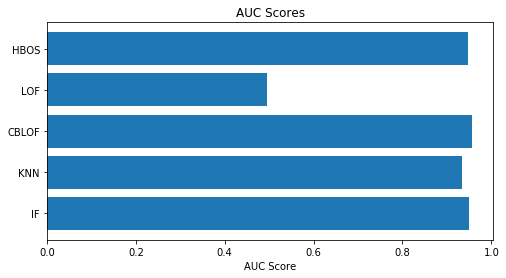

In [131]:
plt.figure(figsize=(8,4))
plt.title('AUC Scores')
plt.barh(range(len(auc_scores)), list(auc_scores.values()), align='center')
plt.yticks(range(len(auc_scores)), list(auc_scores.keys()))
plt.xlabel('AUC Score')
plt.savefig('AUC bar Score.jpeg')
plt.show()

Though AUC is generally a good indicator of how good a model is performing. However since our purpose is to detect outliers and dataset's high imbalance, AUC would be misleading. 

Which is why we need to focus on `recall score.` F1 score is for the reference as well.

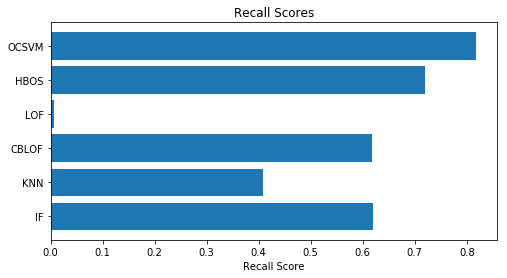

In [139]:
plt.figure(figsize=(8,4))
plt.title('Recall Scores')
plt.barh(range(len(recall_scores)), list(recall_scores.values()), align='center')
plt.yticks(range(len(recall_scores)), list(recall_scores.keys()))
plt.xlabel('Recall Score')
plt.savefig('Recall Score.jpeg')
plt.show()

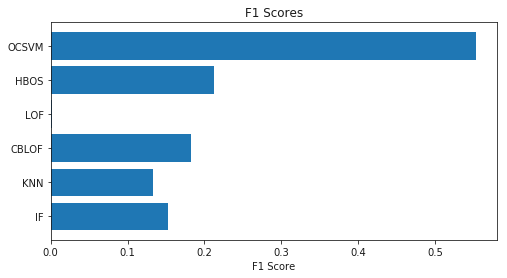

In [314]:
plt.figure(figsize=(8,4))
plt.title('F1 Scores')
plt.barh(range(len(F1_score)), list(F1_score.values()), align='center')
plt.yticks(range(len(F1_score)), list(F1_score.keys()))
plt.xlabel('F1 Score')
plt.savefig('F1 Score.jpeg')
plt.show()

Though OCSVM is outperforming other models but it is not purely an unsupervised model so it's probably best to see it as an reference. Also it is not using the same amount of dataset as others. 

We see that HBOS and CBLOF has captured quite a good amount of frauds seeing its recall scores. LOF on the other hand performed very terribly.

It is once again proved that complicated model does not guarantee its result.

Confusion Matrix

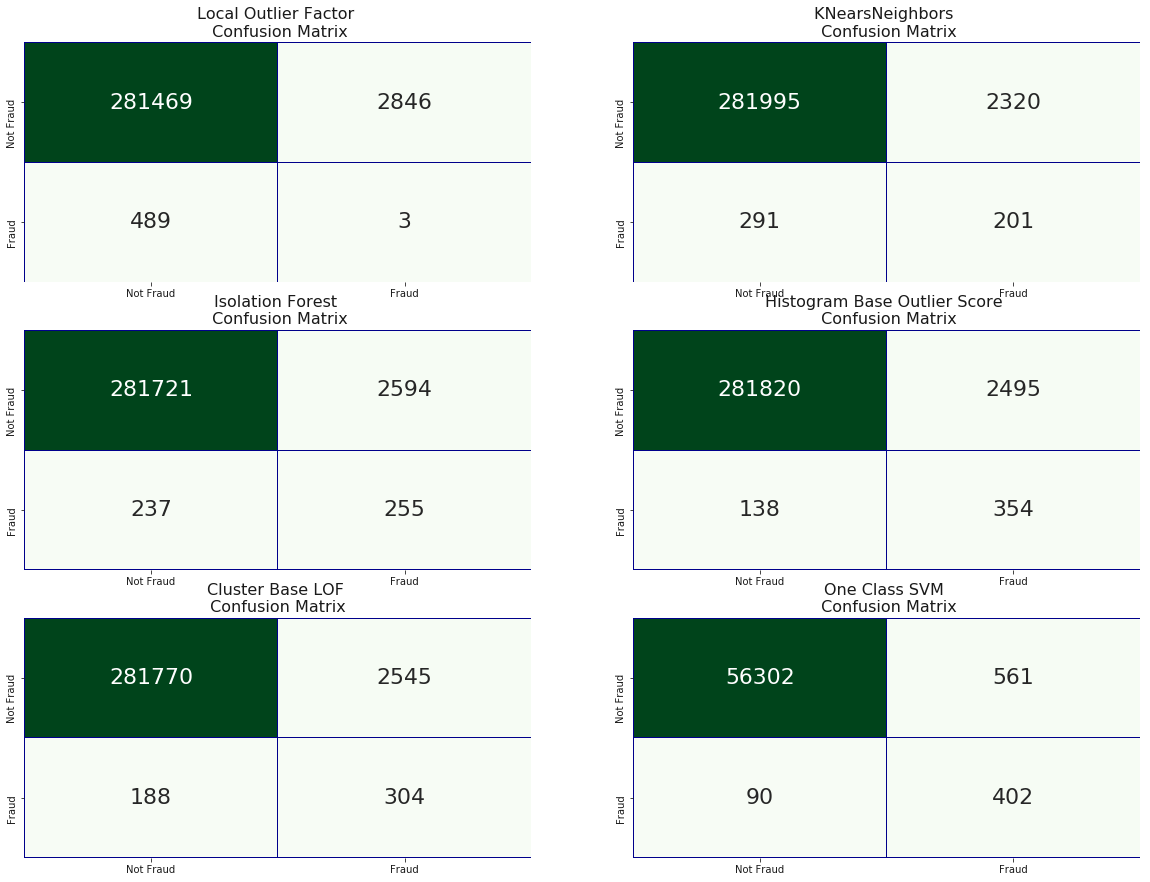

In [302]:
fig, ax = plt.subplots(3, 2,figsize=(20,15))

lof_cf = confusion_matrix(y,lof_predict)
knn_cf = confusion_matrix(y,knn_predict)
if_cf = confusion_matrix(y,IF_predict)
hbos_cf = confusion_matrix(y,hbos_predict)
cblof_cf = confusion_matrix(y,cblof_predict)
ocsvm_cf = confusion_matrix(y_testval,ocsvm_predict)

sns.heatmap(lof_cf, ax=ax[0][0], annot=True,cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue",cmap=plt.cm.Greens,fmt='g')
ax[0, 0].set_title("Local Outlier Factor \n Confusion Matrix", fontsize=16)

sns.heatmap(knn_cf, ax=ax[0][1], annot=True,cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue", cmap=plt.cm.Greens,fmt='g')
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=16)

sns.heatmap(if_cf, ax=ax[1][0], annot=True, cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue",cmap=plt.cm.Greens,fmt='g')
ax[1][0].set_title("Isolation Forest \n Confusion Matrix", fontsize=16)

sns.heatmap(hbos_cf, ax=ax[1][1], annot=True, cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue",cmap=plt.cm.Greens,fmt='g')
ax[1][1].set_title("Histogram Base Outlier Score \n Confusion Matrix",fontsize=16)


sns.heatmap(cblof_cf, ax=ax[2][0], annot=True,cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue", cmap=plt.cm.Greens,fmt='g')
ax[2][0].set_title("Cluster Base LOF \n Confusion Matrix ", fontsize=16)


sns.heatmap(ocsvm_cf, ax=ax[2][1], annot=True,cbar=False,xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],annot_kws={"size": 22}, linewidths=.2,linecolor="Darkblue", cmap=plt.cm.Greens,fmt='g')
ax[2][1].set_title("One Class SVM \n Confusion Matrix", fontsize=16)
plt.savefig('Confusion Matrix.jpeg')

plt.show()

ROC AUC Visualization. (Keep in mind that OCSVM had to use prediction instead of probability for the visualization which explains its low AUC score. It would have been much higher if it had used probability)

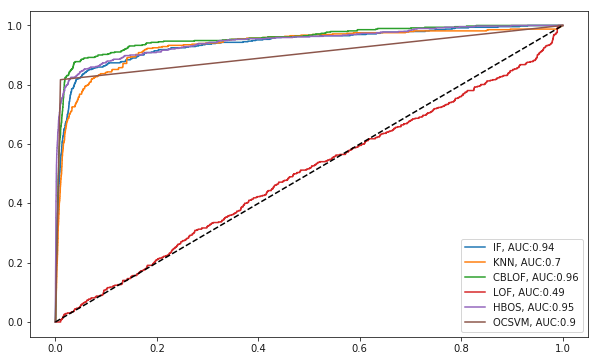

In [343]:
IF_fpr, IF_tpr, IF_thresholds = roc_curve(y, IF_proba)
KNN_fpr, KNN_tpr, KNN_thresholds = roc_curve(y,knn_proba)
CBLOF_fpr, CBLOF_tpr, CBLOF_thresholds = roc_curve(y,cblof_proba)
LOF_fpr, LOF_tpr, LOF_thresholds = roc_curve(y,lof_score)
HBOS_fpr, HBOS_tpr, HBOS_thresholds = roc_curve(y,hbos_proba)
OCSVM_fpr, OCSVM_tpr, OCSVM_thresholds=roc_curve(y_testval,ocsvm_predict)

IF_auc = roc_auc_score(y, IF_proba)
KNN_auc = roc_auc_score(y,knn_predict)
CBLOF_auc = roc_auc_score(y,cblof_proba)
LOF_auc = roc_auc_score(y,lof_score)
HBOS_auc =roc_auc_score(y,hbos_proba)
OCSVM_auc = roc_auc_score(y_testval,ocsvm_predict)

# Visualize 
plt.figure(figsize=(10,6))
plt.plot(IF_fpr, IF_tpr, label=f'IF, AUC:{np.round(IF_auc, 2)}')
plt.plot(KNN_fpr, KNN_tpr, label=f'KNN, AUC:{np.round(KNN_auc, 2)}')
plt.plot(CBLOF_fpr, CBLOF_tpr, label=f'CBLOF, AUC:{np.round(CBLOF_auc, 2)}')
plt.plot(LOF_fpr, LOF_tpr, label=f'LOF, AUC:{np.round(LOF_auc, 2)}')
plt.plot(HBOS_fpr, HBOS_tpr, label=f'HBOS, AUC:{np.round(HBOS_auc, 2)}')
plt.plot(OCSVM_fpr, OCSVM_tpr, label=f'OCSVM, AUC:{np.round(OCSVM_auc, 2)}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc='best')
plt.savefig('AUC Score.jpeg')
plt.show()

# Final step: Ensemble
We have tried multiple unsupervised ML models and have seen what it does. By theory each models have their own distinct mathematical basis to detect outliers and I believe there are instances that one model could capture but others could not.

It would be best to ensemble those models so we can capture as many suspicious transactions as possible.

# Chossing models to ensemble
Though we have seen accuracy metrics, we are pretending we have not seen it because this is an unsupervised ML project. We are choosing our models purely based on time it takes to run instead. Hence we are using HBOS, CBLOF and IF.

In [223]:
# We use feature bagged model results (To mitigate randomness and overfitting)
HBOS_flagged = X[FB_hbos_predict==1].index
IF_flagged =X[FB_IF_predict==1].index
CBLOF_flagged = X[FB_cblof_predict==1].index

In [224]:
#Combine all the lists of 'predicted' fraudulent transactions
voter = []
for i in range(len(HBOS_flagged)) : 
    voter.append(HBOS_flagged[i])
    voter.append(IF_flagged[i])
    voter.append(CBLOF_flagged[i])

In [225]:
# Separating index(index number of transaction) and how many votes it had(how many duplicates)
votes = np.unique(voter,return_counts=True)
Numvote=votes[1]
TransactIndex=votes[0]

In [226]:
#Make it a dataframe
Votelist = pd.DataFrame(list(zip(TransactIndex,Numvote)),columns=['Transaction','Vote'])

#Sort in descending order by value of votes
Votelist = Votelist.sort_values('Vote',ascending=False)
Votelist.head()

,Transaction,Vote
2267,141260,3
2159,132286,3
2231,138706,3
2227,138286,3
2226,138230,3


In [242]:
#Adding another column to the 'X' dataframe and converting its value to 1 if the transaction was in the list of ensemble model we did above and 0 if it was not there.
X['vote'] = X.index.values
vote_range = Votelist['Transaction'].values

new_vote = X['vote'].isin(vote_range)

X['vote'] = np.where(new_vote==False,0,1)

print(confusion_matrix(y,X['vote']))
print(classification_report(y,X['vote']))

[[280140   4175]
 [   133    359]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.08      0.73      0.14       492

    accuracy                           0.98    284807
   macro avg       0.54      0.86      0.57    284807
weighted avg       1.00      0.98      0.99    284807



In [243]:
# Checking for suspicious transactions that has '3' votes

X['vote3'] = X.index.values
vote_range = Votelist[Votelist['Vote']==3]['Transaction'].values

new_vote3 = X['vote3'].isin(vote_range)

X['vote3'] = np.where(new_vote3==False,0,1)

print(confusion_matrix(y,X['vote3']))
print(classification_report(y,X['vote3']))

[[283213   1102]
 [   210    282]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.20      0.57      0.30       492

    accuracy                           1.00    284807
   macro avg       0.60      0.78      0.65    284807
weighted avg       1.00      1.00      1.00    284807



In [237]:
# Checking for suspicious transactions that has '2' votes
X['vote2'] = X.index.values
vote_range = Votelist[Votelist['Vote']==2]['Transaction'].values

new_vote2 = X['vote2'].isin(vote_range)

X['vote2'] = np.where(new_vote2==False,0,1)

print(confusion_matrix(y,X['vote2']))
print(classification_report(y,X['vote2']))

[[283114   1201]
 [   451     41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.03      0.08      0.05       492

    accuracy                           0.99    284807
   macro avg       0.52      0.54      0.52    284807
weighted avg       1.00      0.99      1.00    284807



In [239]:
# Checking for suspicious transactions that has '1' votes
X['vote1'] = X.index.values
vote_range = Votelist[Votelist['Vote']==1]['Transaction'].values

new_vote1 = X['vote1'].isin(vote_range)

X['vote1'] = np.where(new_vote1==False,0,1)

print(confusion_matrix(y,X['vote1']))
print(classification_report(y,X['vote1']))

[[282443   1872]
 [   456     36]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.02      0.07      0.03       492

    accuracy                           0.99    284807
   macro avg       0.51      0.53      0.51    284807
weighted avg       1.00      0.99      0.99    284807



Disappointingly enough, the recall has not gone up enough as much as I expected. I am not able to explain why it did not go up much higher than using one best unsupervised machine learning model(HBOS) at this stage yet.

However what separated suspicious transactions by its number of votes it had. We saw that transactions with 3 votes got higher precision even though the recall score has gone down. Which is obvious because we predicted way less numbers of transactions as suspicious. We can see that at least my theory about transactions with the highest number of votes being most suspicious is correct. 

Precision score is not to be ignored because too low precision score will impact your business as it will interfere with the flow of business by investigating each one of them.

I believe it would have been different if we had more dataset or if I had done more feature engineering with non-anonymized feature dataset.

# Conclusion and Future plan

For anomaly detection in financial crimes like credit card frauds, it would be best to tackle the issue from various angles which means we want to use multiple models even for the slightest improvement.

Hopefully with different and larger dataset my way of ensembling multiple models will be proven more effective than what we saw today.

We would have been able to do many more feature engineering than just 2 that I did today with full access to features. 

One day we will try outlier detection with different dataset such as network intrusion or fund transaction for money laundering detection.